https://www.youtube.com/watch?v=luiJttJVeBA&ab_channel=datadrenaline

https://www.youtube.com/watch?v=czd9a2Rc-h4&ab_channel=DataCamp

https://dockerlabs.collabnix.com/docker/cheatsheet/

https://mlconference.ai/blog/real-time-anomaly-detection-with-kafka-and-isolation-forests/?gclid=Cj0KCQjwqc6aBhC4ARIsAN06NmMN_ObP_nI-oxDgHQZq9jKOVwJFRe2lTLMkhpQgWJaPVVWH9RuOQjYaAplvEALw_wcB

https://medium.com/@sidjain1412/anomaly-detection-for-time-series-data-dc92a1d1a49f

https://medium.com/@alex.huang1117/how-to-detect-anomalies-without-labels-project-overview-9b91332201d5

In [1]:

import tensorflow as tf
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pyspark.sql.functions import *
spark = SparkSession.builder.master('local[*]').appName('spark_app').getOrCreate()
df = spark.read.csv('DBA80.csv', header=True,inferSchema=True, sep=';').orderBy('TimeStamp',ascending = True)

df = df.withColumn('ActualPos', regexp_replace('ActualPos', ',', '.'))
df = df.withColumn('ActualPos', df['ActualPos'].cast('double'))
df.printSchema()

pdf = df.toPandas()


root
 |-- TimeStamp: timestamp (nullable = true)
 |-- ActualPos: double (nullable = true)
 |-- ActualForce: integer (nullable = true)
 |-- Nahtnummer: string (nullable = true)
 |-- LaserPwr: integer (nullable = true)
 |-- Befehl: string (nullable = true)



In [3]:
pdf.head(10)


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636
5,2020-09-22 10:52:38.566,1.9,-693,KHO,376,PUTG348_46360631
6,2020-09-22 10:52:39.299,1.6,-691,KIG,376,PUTG348_46360630
7,2020-09-22 10:52:40.037,1.5,-705,KHP,375,PNB335
8,2020-09-22 10:52:40.431,-11.4,307,KHP,0,PNB343
9,2020-09-22 10:52:44.129,0.3,-688,FIPC,382,PUTG348_46360642


In [4]:
pdf.describe()


,ActualPos,ActualForce,LaserPwr
count,1000000.000000,1000000.000000,1000000.000000
mean,-8.174710,-574.953371,268.952781
std,136.541504,4021.754611,177.650401
min,-8192.000000,-151386.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,8191.900000,151388.000000,408.000000


In [5]:
q2 = 0.99
q1 = 0.01
multi = 1.5
q2_F = pdf.ActualForce.quantile(q2)
q1_F = pdf.ActualForce.quantile(q1)

iqr_F = q2_F-q1_F

q2_P = pdf.ActualPos.quantile(q2)
q1_P = pdf.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P


pdf_clean = pdf[(pdf.ActualForce < q2_F+(multi*iqr_F)) & (pdf.ActualForce > q1_F-(multi*iqr_F)) & (pdf.ActualPos < q2_P+(multi*iqr_P)) & (pdf.ActualPos > q1_P-(multi*iqr_P))]

pdf_clean.describe()


,ActualPos,ActualForce,LaserPwr
count,999029.000000,999029.000000,999029.000000
mean,-9.643305,-514.509987,269.190766
std,25.166300,373.544499,177.549117
min,-72.800000,-1922.000000,0.000000
25%,-0.500000,-693.000000,0.000000
50%,0.800000,-691.000000,376.000000
75%,1.400000,-520.000000,396.000000
max,22.300000,718.000000,408.000000


In [54]:
pdf_clean.sort_values('TimeStamp')

,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,day,week,year
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637,2020-09-22,39,2020
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632,2020-09-22,39,2020
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634,2020-09-22,39,2020
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635,2020-09-22,39,2020
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636,2020-09-22,39,2020
...,...,...,...,...,...,...,...,...,...
999995,2021-11-09 01:13:34.452,-3.9,566,EMMC,0,PNB117,2021-11-09,45,2021
999996,2021-11-09 01:13:40.938,1.0,-693,KGM,398,PUTG348_46360622,2021-11-09,45,2021
999997,2021-11-09 01:13:46.855,0.4,-691,KGL,0,PNB250,2021-11-09,45,2021
999998,2021-11-09 01:13:50.605,1.6,-922,EMME,396,PNB265,2021-11-09,45,2021


In [6]:
pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp',ascending=False)

,Befehl,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr
90,PUTG348_46360638,53644,53644,53644,53644,53644
77,PUTG348_46360610,45044,45044,45044,45044,45044
92,PUTG348_46360641,44776,44776,44776,44776,44776
78,PUTG348_46360622,44522,44522,44522,44522,44522
84,PUTG348_46360632,44202,44202,44202,44202,44202
...,...,...,...,...,...,...
39,PNB320,1,1,1,1,1
53,PNB42,1,1,1,1,1
118,PUTG463_46360775,1,1,1,1,1
120,PUTG463_46360778,1,1,1,1,1


<AxesSubplot: xlabel='TimeStamp', ylabel='Befehl'>

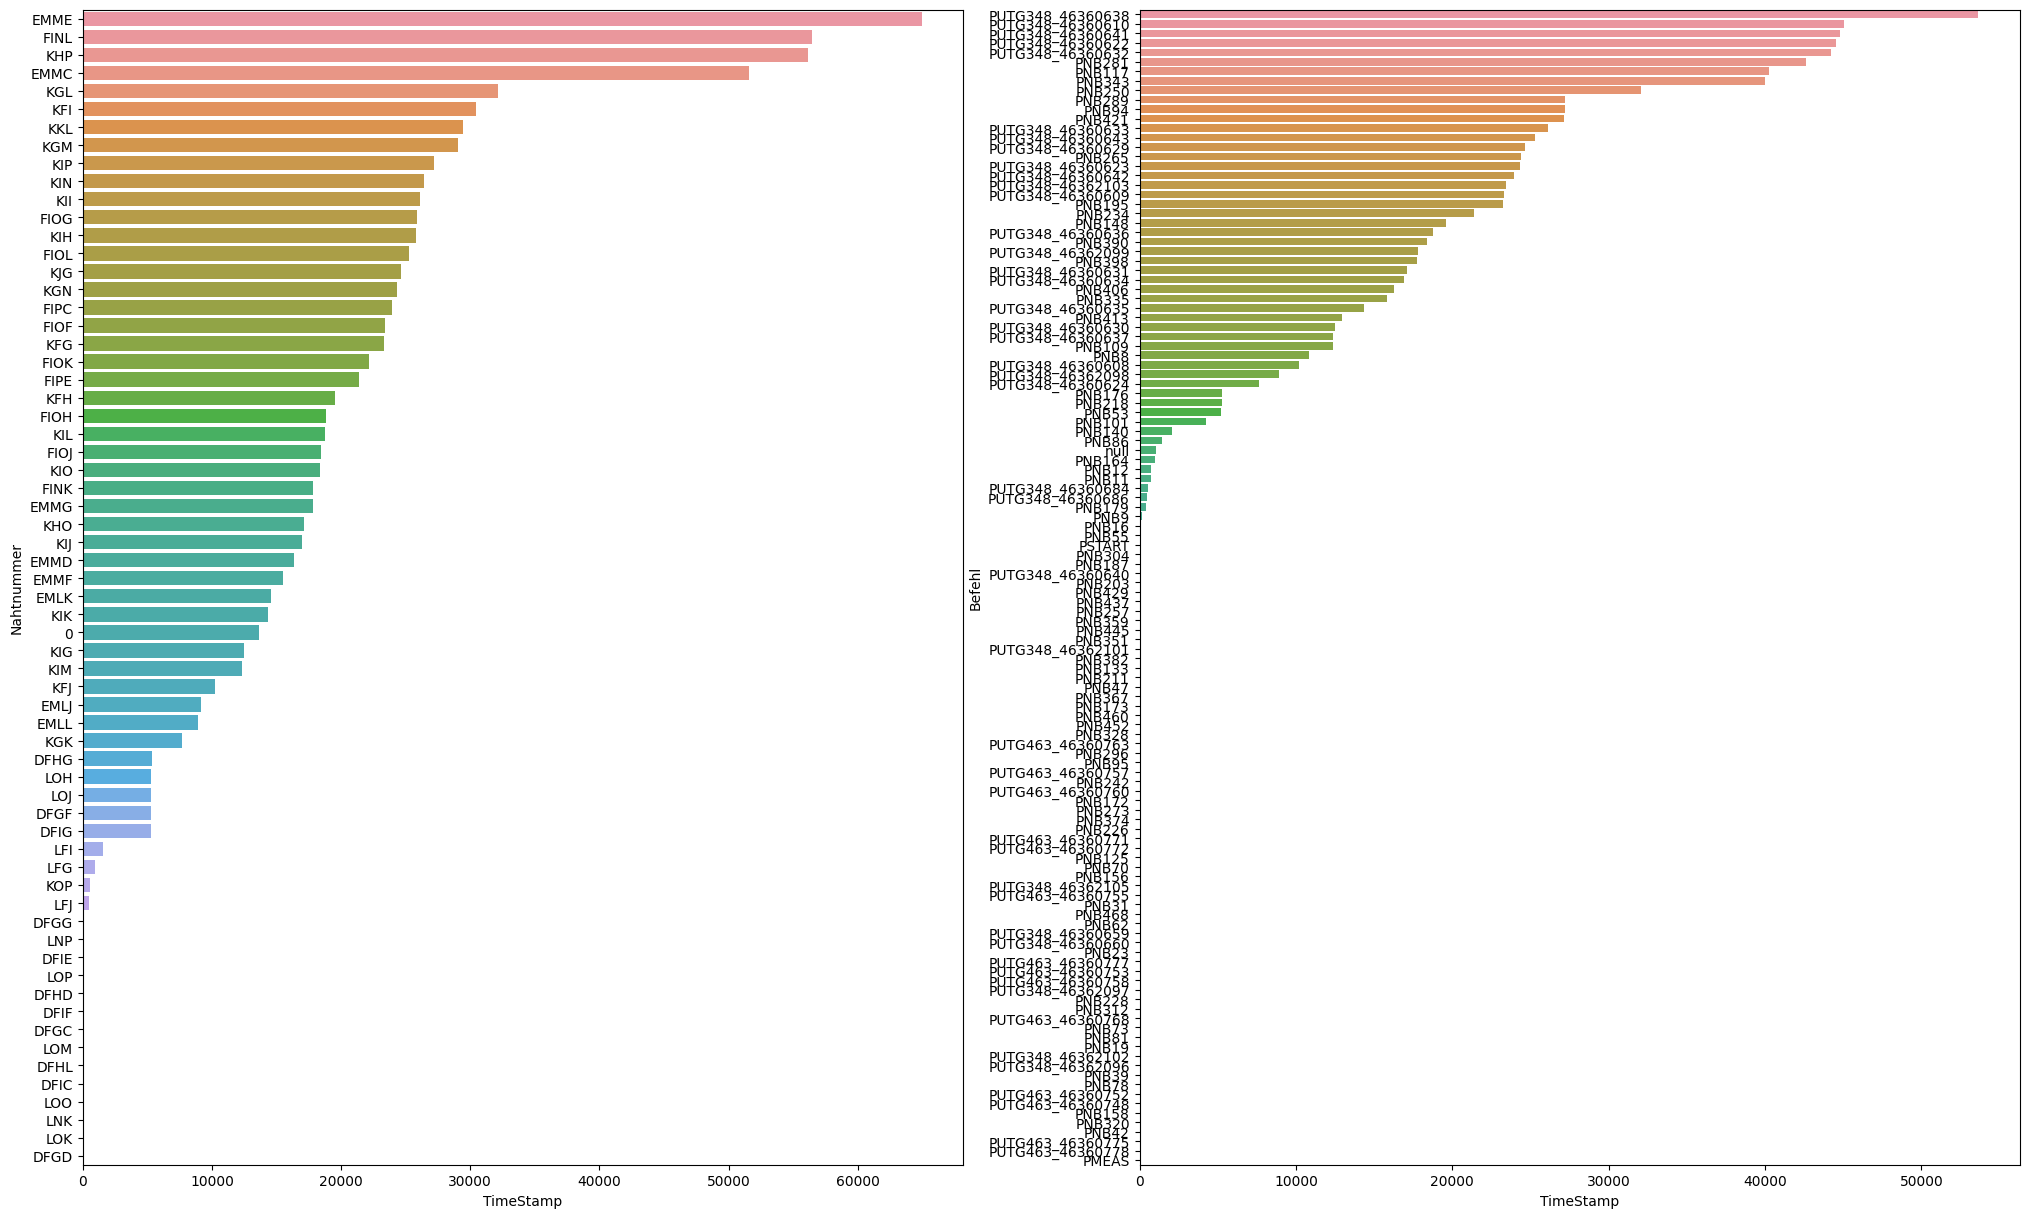

In [7]:
fig,ax = plt.subplots(1,2,figsize=(25,15))
sns.barplot(data=pdf_clean.groupby('Nahtnummer').count().reset_index().sort_values(
    'TimeStamp', ascending=False), y='Nahtnummer', x='TimeStamp', ax=ax[0])
sns.barplot(data=pdf_clean.groupby('Befehl').count().reset_index().sort_values('TimeStamp', ascending=False),
            y='Befehl', x='TimeStamp', ax=ax[1])


In [72]:
pvtble=pdf_clean.pivot_table(index='Befehl',columns='Nahtnummer',values='ActualPos',aggfunc='count')
pvtble


Nahtnummer,0,DFGC,DFGD,DFGF,DFGG,DFHD,DFHG,DFHL,DFIC,DFIE,...,LFI,LFJ,LNK,LNP,LOH,LOJ,LOK,LOM,LOO,LOP
Befehl,,,,,,,,,,,,,,,,,,,,,
PMEAS,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNB101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4232.0,NaN,NaN,NaN,NaN,NaN
PNB109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1061.0,NaN,NaN,NaN,1.0,NaN
PNB11,721.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PNB117,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,1.0,1.0,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PUTG463_46360772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PUTG463_46360775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PUTG463_46360777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(-936.0, 266.0)
(0.6, 14.0)


<AxesSubplot: xlabel='ActualPos', ylabel='ActualForce'>

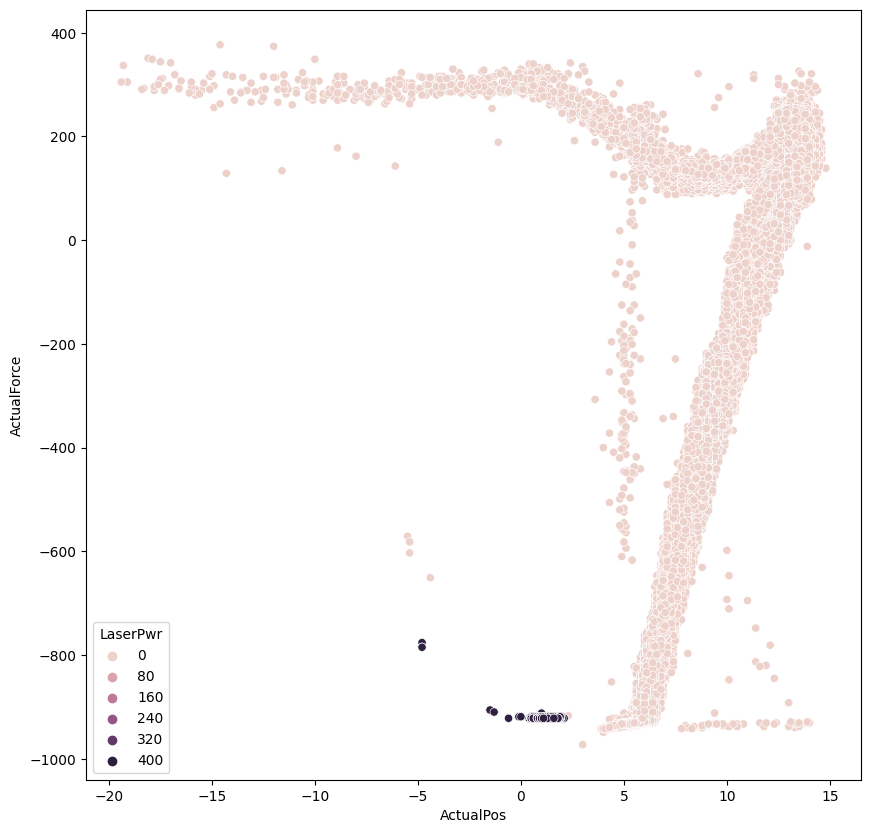

In [9]:
pdf_n=pdf[(pdf.Nahtnummer == 'EMME')]

q2=0.99
q1=0.01
multi=1.5
q2_F = pdf_n.ActualForce.quantile(q2)
q1_F = pdf_n.ActualForce.quantile(q1)

iqr_F=q2_F-q1_F

q2_P = pdf_n.ActualPos.quantile(q2)
q1_P = pdf_n.ActualPos.quantile(q1)

iqr_P = q2_P-q1_P

print((q1_F,q2_F))
print((q1_P, q2_P))

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=pdf_n[(pdf_n.ActualForce < q2_F+(multi*iqr_F)) & (pdf_n.ActualForce > q1_F-(multi*iqr_F)) &
                           (pdf_n.ActualPos < q2_P+(multi*iqr_P)) & (pdf_n.ActualPos > q1_P-(multi*iqr_P))], x='ActualPos', y='ActualForce', hue='LaserPwr')


<AxesSubplot: xlabel='ActualPos', ylabel='Count'>

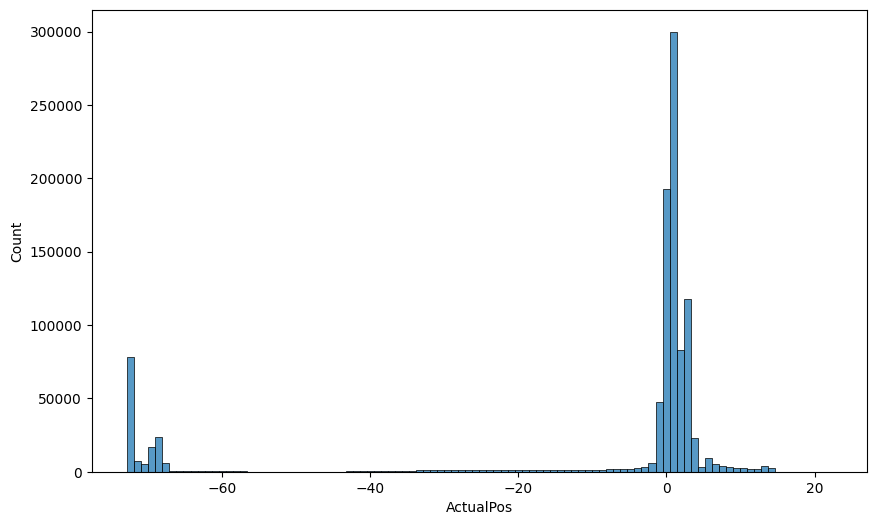

In [10]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean,x='ActualPos', bins=100)

<AxesSubplot: xlabel='ActualPos', ylabel='Count'>

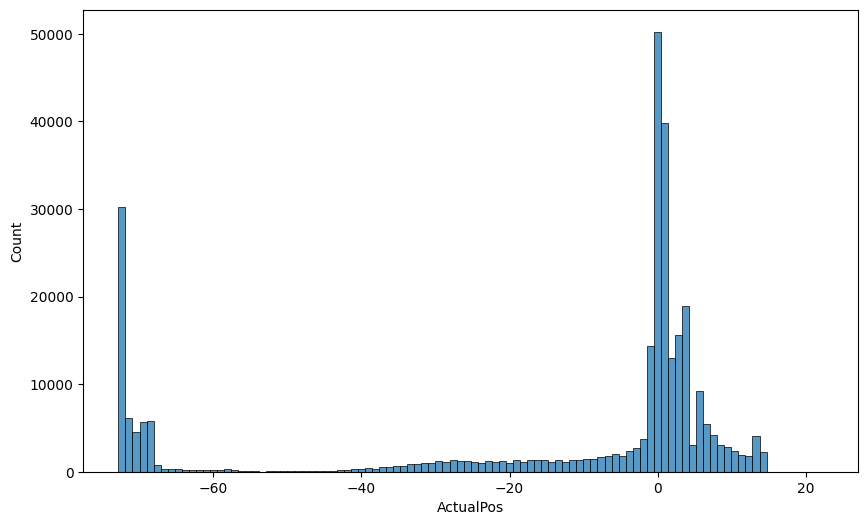

In [11]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean[pdf_clean.LaserPwr == 0], x='ActualPos', bins=100)

<AxesSubplot: xlabel='ActualPos', ylabel='Count'>

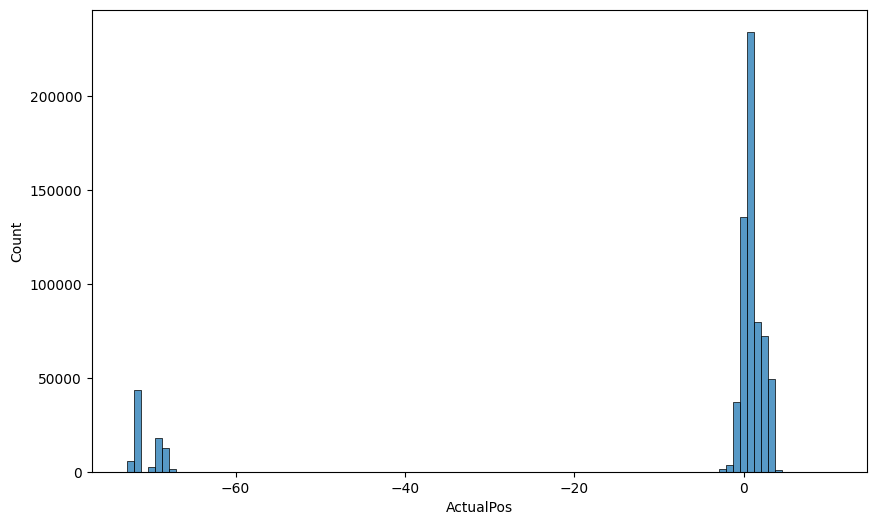

In [12]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean[pdf_clean.LaserPwr != 0], x='ActualPos', bins=100)

In [14]:
pdf_clean


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,day
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637,2020-09-22
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632,2020-09-22
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634,2020-09-22
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635,2020-09-22
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636,2020-09-22
...,...,...,...,...,...,...,...
999995,2021-11-09 01:13:34.452,-3.9,566,EMMC,0,PNB117,2021-11-09
999996,2021-11-09 01:13:40.938,1.0,-693,KGM,398,PUTG348_46360622,2021-11-09
999997,2021-11-09 01:13:46.855,0.4,-691,KGL,0,PNB250,2021-11-09
999998,2021-11-09 01:13:50.605,1.6,-922,EMME,396,PNB265,2021-11-09


In [59]:
pdf_clean['day']=pdf_clean.TimeStamp.map(lambda d: d.date())
pdf_clean['week'] = pdf_clean.TimeStamp.map(lambda d: str(d.week)+"_"+str(d.year))
pdf_clean['year'] = pdf_clean.TimeStamp.map(lambda d: d.year)


In [60]:
pdf_clean


,TimeStamp,ActualPos,ActualForce,Nahtnummer,LaserPwr,Befehl,day,week,year
0,2020-09-22 10:52:31.972,-1.3,-695,KIM,377,PUTG348_46360637,2020-09-22,39_2020,2020
1,2020-09-22 10:52:32.522,-1.0,-684,KIO,0,PUTG348_46360632,2020-09-22,39_2020,2020
2,2020-09-22 10:52:34.425,0.6,-691,KIJ,375,PUTG348_46360634,2020-09-22,39_2020,2020
3,2020-09-22 10:52:35.141,1.1,-691,KIK,375,PUTG348_46360635,2020-09-22,39_2020,2020
4,2020-09-22 10:52:35.879,1.4,-693,KIL,335,PUTG348_46360636,2020-09-22,39_2020,2020
...,...,...,...,...,...,...,...,...,...
999995,2021-11-09 01:13:34.452,-3.9,566,EMMC,0,PNB117,2021-11-09,45_2021,2021
999996,2021-11-09 01:13:40.938,1.0,-693,KGM,398,PUTG348_46360622,2021-11-09,45_2021,2021
999997,2021-11-09 01:13:46.855,0.4,-691,KGL,0,PNB250,2021-11-09,45_2021,2021
999998,2021-11-09 01:13:50.605,1.6,-922,EMME,396,PNB265,2021-11-09,45_2021,2021


In [61]:
test_df=pdf_clean[pdf_clean.LaserPwr==0]

In [99]:
test_df.groupby(['week','year']).count().sort_values(['year','week']).count()

TimeStamp      32
ActualPos      32
ActualForce    32
Nahtnummer     32
LaserPwr       32
Befehl         32
day            32
dtype: int64

In [45]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

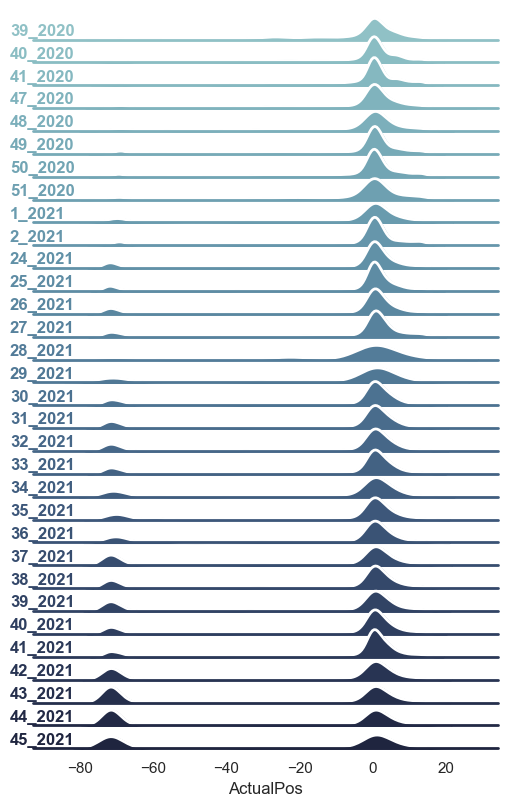

In [113]:
test_df = pdf_clean[pdf_clean.LaserPwr == 0]
x_val = "ActualPos"

pal = sns.cubehelix_palette(32, rot=-.25, light=.7)
g = sns.FacetGrid(test_df, row="week", hue="week",
                  aspect=20, height=.3, palette=pal)

g.map(sns.kdeplot, x_val,
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, x_val, clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


def label(x, color, label):
    ax = plt.gca()
    ax.text(-.05, .3, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    

g.map(label, x_val)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)


<AxesSubplot: xlabel='week', ylabel='Nahtnummer'>

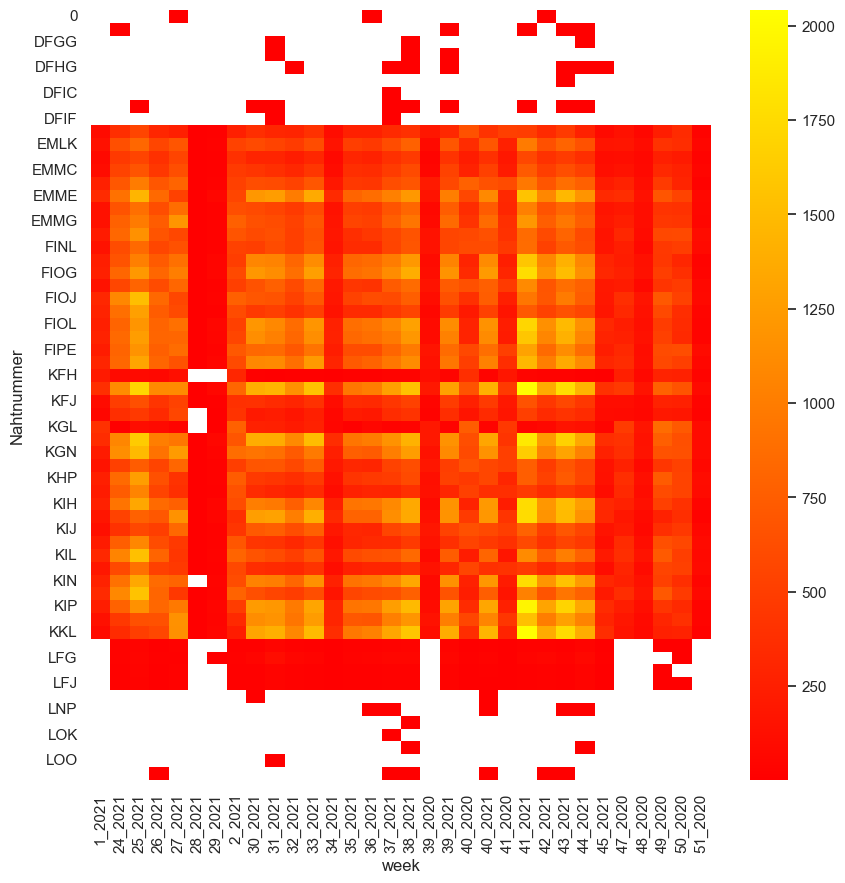

In [89]:
pvtble = test_df.pivot_table(index='Nahtnummer', columns='week', values='ActualPos', aggfunc='count')
pvtble
fig = plt.figure(figsize=(10,10))
sns.heatmap(pvtble, cmap="autumn")


<AxesSubplot: xlabel='week', ylabel='Befehl'>

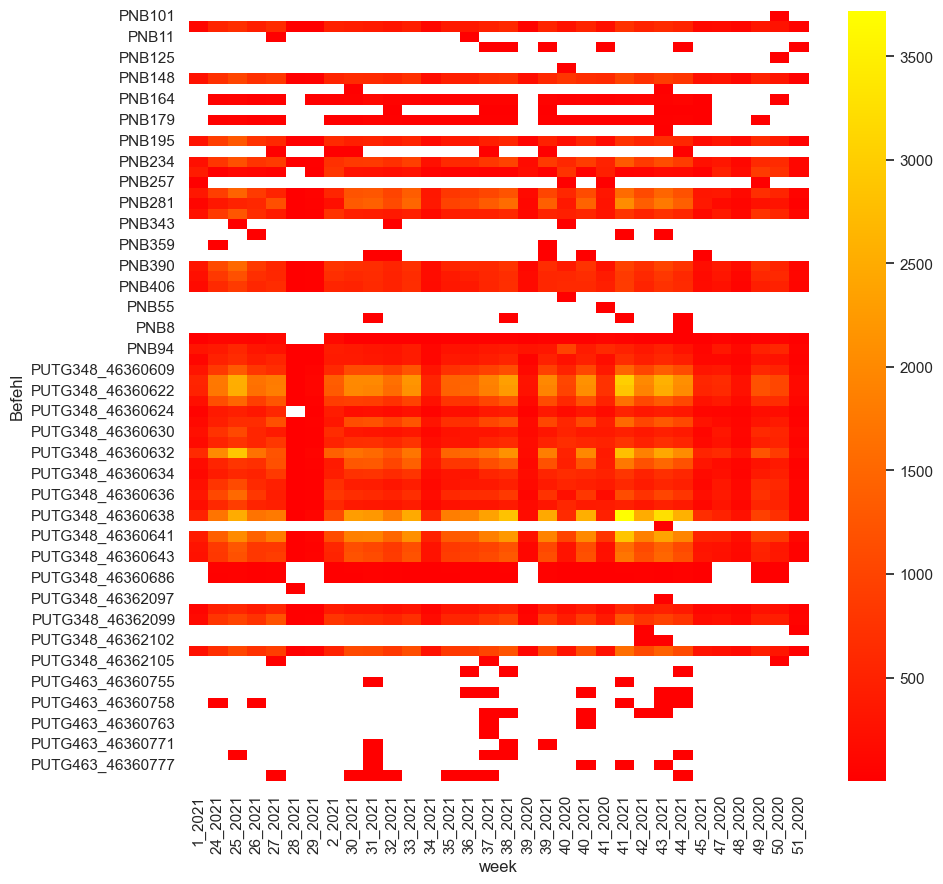

In [90]:
pvtble = test_df.pivot_table(index='Befehl', columns='week', values='ActualPos', aggfunc='count')
pvtble
fig = plt.figure(figsize=(10, 10))
sns.heatmap(pvtble, cmap="autumn")


In [ ]:
fig = plt.figure(figsize=(10,6))
sns.histplot(data=pdf_clean, x='ActualForce', bins=300)

In [ ]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(data=pdf_clean, x='LaserPwr', bins=100)


In [ ]:

fig = plt.figure(figsize=(10, 25))
sns.barplot(data=pdf.groupby('Date').count().reset_index(),x='TimeStamp',y='Date')


In [ ]:

fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualPos')
#g.set(yscale='log')


In [ ]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='ActualForce')


In [ ]:
fig = plt.figure(figsize=(25, 5))

g = sns.scatterplot(data=pdf[(pdf.TimeStamp > '2020-11-17 12:00:00') &
                 (pdf.TimeStamp < '2020-11-18 01:10:00')], x='TimeStamp', y='LaserPwr')


In [ ]:
pdf[(pdf.TimeStamp>"2020-11-18 01:00:00")&(pdf.TimeStamp<"2020-11-18 01:30:00")]

In [ ]:
pdf[pdf.ActualPos > 1].describe()

### Data Preperation

In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

Train_size = int(0.7 * len(pdf_clean))

X_Train, X_Test = pdf_clean.iloc[0:Train_size +1, :], pdf_clean.iloc[Train_size:-1, :]

#X_Train, X_Test = pdf.iloc[0:Train_size +1, :], pdf.iloc[Train_size:-1, :]


In [ ]:
one_hot = OneHotEncoder(handle_unknown='ignore')

x = one_hot.fit_transform(X_Train[['Nahtnummer', 'Befehl']])
X_train = np.concatenate((X_Train[['ActualPos', 'ActualForce', 'LaserPwr']].to_numpy(), x.toarray()), axis=1)


In [ ]:
x = one_hot.transform(X_Test[['Nahtnummer', 'Befehl']])
X_test = np.concatenate((X_Test[['ActualPos', 'ActualForce', 'LaserPwr']].to_numpy(), x.toarray()), axis=1)


### Model Selection

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto', init='random',
                  verbose=2, perplexity=80, n_iter=350,random_state=42)

tsne_result = tsne.fit_transform(X_train[:100000, :])


In [ ]:
X_Train["ActualPos_cat"] = pd.cut(X_Train["ActualPos"], bins=[-np.inf,-75, -50, -40, -20,-2, 2, 20, np.inf], labels=['-out','75-50', '50-40', '40-20', '20-2', '2-2','2-25', '+out'])
X_Train["LaserPwr_cat"] = pd.cut(X_Train["LaserPwr"], bins=[-1,0, 10, 300, 380,410, np.inf], labels=['0','>0-10', '10-300', '300-380', '380-410','410'])
X_Train["ActualForce_cat"] = pd.cut(X_Train["ActualForce"], bins=[-np.inf,-2000, -800, -500, -250,-50,0,50, 700, np.inf], labels=['-out', '200-80', '80-50', '50-25','25-5','5-0','0-5','5-70','+out'])

In [ ]:
tsne_result_df = X_Train.iloc[:100000, :]
tsne_result_df['tsne-2d-one'] = tsne_result[:,0]
tsne_result_df['tsne-2d-two'] = tsne_result[:,1]
tsne_result_df["ActualPos_cat"] = pd.cut(X_Train["ActualPos"], bins=[-np.inf, -75, -50, -40, -20, -2,
                                  2, 20, np.inf], labels=['-out', '75-50', '50-40', '40-20', '20-2', '2-2', '2-25', '+out'])
tsne_result_df["LaserPwr_cat"] = pd.cut(X_Train["LaserPwr"], bins=[-1, 0, 10, 300, 380,
                                 410, np.inf], labels=['0', '>0-10', '10-300', '300-380', '380-410', '410'])
tsne_result_df["ActualForce_cat"] = pd.cut(X_Train["ActualForce"], bins=[-np.inf, -2000, -800, -500, -250, -50,
                                    0, 50, 700, np.inf], labels=['-out', '200-80', '80-50', '50-25', '25-5', '5-0', '0-5', '5-70', '+out'])


In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=tsne_result_df,
    hue='ActualPos_cat',
    x='tsne-2d-one', y='tsne-2d-two',
    #palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.4,
    size="ActualForce_cat",
    sizes=(100, 40), 
    style="LaserPwr_cat"
)


### Learning 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

Train_size = int(0.7 * len(pdf))

X_Train, X_Test = pdf_clean.iloc[0:Train_size +1, :], pdf_clean.iloc[Train_size:-1, :]

one_hot = OneHotEncoder(handle_unknown='ignore')

x = one_hot.fit_transform(X_Train[['Nahtnummer', 'Befehl']])
X_train = np.concatenate(
    (X_Train[['ActualPos', 'ActualForce', 'LaserPwr']].to_numpy(), x.toarray()), axis=1)

x = one_hot.transform(X_Test[['Nahtnummer', 'Befehl']])
X_test = np.concatenate(
    (X_Test[['ActualPos', 'ActualForce', 'LaserPwr']].to_numpy(), x.toarray()), axis=1)


In [ ]:
X_train_pca.shape


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


pca = PCA(n_components=0.95, svd_solver='full')

pca.fit(X_train)

X_train_pca = pca.transform(X_train)


In [ ]:
X_train=X_train_pca


In [ ]:
from sklearn.ensemble import IsolationForest

estimator = IsolationForest(n_estimators=50, max_samples='auto', contamination='auto',
                            max_features=20, bootstrap=False, n_jobs=-1, random_state=42, verbose=2, warm_start=False)

estimator.fit(X_train)


In [ ]:
pred = estimator.predict(X_train)

In [ ]:
np.sum(pred)


In [ ]:
len(pred)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate='auto', init='random',
            verbose=2, perplexity=80, n_iter=350, random_state=42)

tsne_result = tsne.fit_transform(X_train[:100000, :])


In [ ]:
tsne_result_df = X_Train.iloc[:100000, :]
tsne_result_df['tsne-2d-one'] = tsne_result[:, 0]
tsne_result_df['tsne-2d-two'] = tsne_result[:, 1]
tsne_result_df["ActualPos_cat"] = pd.cut(X_Train["ActualPos"], bins=[-np.inf, -75, -50, -40, -20, -2,
                                                                     2, 20, np.inf], labels=['-out', '75-50', '50-40', '40-20', '20-2', '2-2', '2-25', '+out'])
tsne_result_df["LaserPwr_cat"] = pd.cut(X_Train["LaserPwr"], bins=[-1, 0, 10, 300, 380,
                                                                   410, np.inf], labels=['0', '>0-10', '10-300', '300-380', '380-410', '410'])
tsne_result_df["ActualForce_cat"] = pd.cut(X_Train["ActualForce"], bins=[-np.inf, -2000, -800, -500, -250, -50,
                                                                         0, 50, 700, np.inf], labels=['-out', '200-80', '80-50', '50-25', '25-5', '5-0', '0-5', '5-70', '+out'])
tsne_result_df['detection'] = pred[:100000]


In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=tsne_result_df,
    hue='ActualPos_cat',
    x='tsne-2d-one', y='tsne-2d-two',
    #palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.4,
    size="ActualForce_cat",
    sizes=(100, 40),
    style="detection"
)


In [ ]:
tsne_result_df[tsne_result_df.detection == -1].head(50)


In [ ]:
plt.figure(figsize=(16, 10))
sns.scatterplot(
    data=tsne_result_df[tsne_result_df.detection == -1],
    hue='ActualPos_cat',
    x='tsne-2d-one', y='tsne-2d-two',
    #palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.4,
    size="ActualForce_cat",
    sizes=(100, 40),
    style="ActualForce_cat"
)
